### Introduction to Project

For this project, you will be creating a movie recommendation system using the MovieLens dataset. The version of movielens included in the dslabs package (which was used for some of the exercises in PH125.8x: Data Science: Machine Learning) is just a small subset of a much larger dataset with millions of ratings. You can find the entire latest MovieLens dataset here. You will be creating your own recommendation system using all the tools we have shown you throughout the courses in this series. We will use the 10M version of the MovieLens dataset to make the computation a little easier.

You will download the MovieLens data and run code we will provide to generate your datasets.

First, there will be a short quiz on the MovieLens data. You can view this quiz as an opportunity to familiarize yourself with the data in order to prepare for your project submission.

Second, you will train a machine learning algorithm using the inputs in one subset to predict movie ratings in the validation set. Your project itself will be assessed by peer grading.


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import string

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


# from pycaret.classification import *
# from pycaret.clustering import *
from pycaret.regression import *

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df

,userId,movieId,rating,timestamp,title,genres
0,1,122,5.0,838985046,Boomerang (1992),Comedy|Romance
1,1,185,5.0,838983525,"Net, The (1995)",Action|Crime|Thriller
2,1,292,5.0,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
3,1,316,5.0,838983392,Stargate (1994),Action|Adventure|Sci-Fi
4,1,329,5.0,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi
...,...,...,...,...,...,...
9000050,32620,33140,3.5,1173562747,Down and Derby (2005),Children|Comedy
9000051,40976,61913,3.0,1227767528,Africa addio (1966),Documentary
9000052,59269,63141,2.0,1226443318,Rockin' in the Rockies (1945),Comedy|Musical|Western
9000053,60713,4820,2.0,1119156754,Won't Anybody Listen? (2000),Documentary


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000055 entries, 0 to 9000054
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 412.0+ MB


In [5]:
df.describe(include='all')

,userId,movieId,rating,timestamp,title,genres
count,9.000055e+06,9.000055e+06,9.000055e+06,9.000055e+06,9000055,9000055
unique,NaN,NaN,NaN,NaN,10676,797
top,NaN,NaN,NaN,NaN,Pulp Fiction (1994),Drama
freq,NaN,NaN,NaN,NaN,31362,733296
mean,3.586982e+04,4.121702e+03,3.512465e+00,1.032616e+09,NaN,NaN
std,2.058525e+04,8.942108e+03,1.060331e+00,1.159668e+08,NaN,NaN
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08,NaN,NaN
25%,1.812400e+04,6.480000e+02,3.000000e+00,9.467683e+08,NaN,NaN
50%,3.573800e+04,1.834000e+03,4.000000e+00,1.035494e+09,NaN,NaN
75%,5.360700e+04,3.626000e+03,4.000000e+00,1.126751e+09,NaN,NaN


In [6]:
df.shape

(9000055, 6)

In [7]:
df.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object')

In [8]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

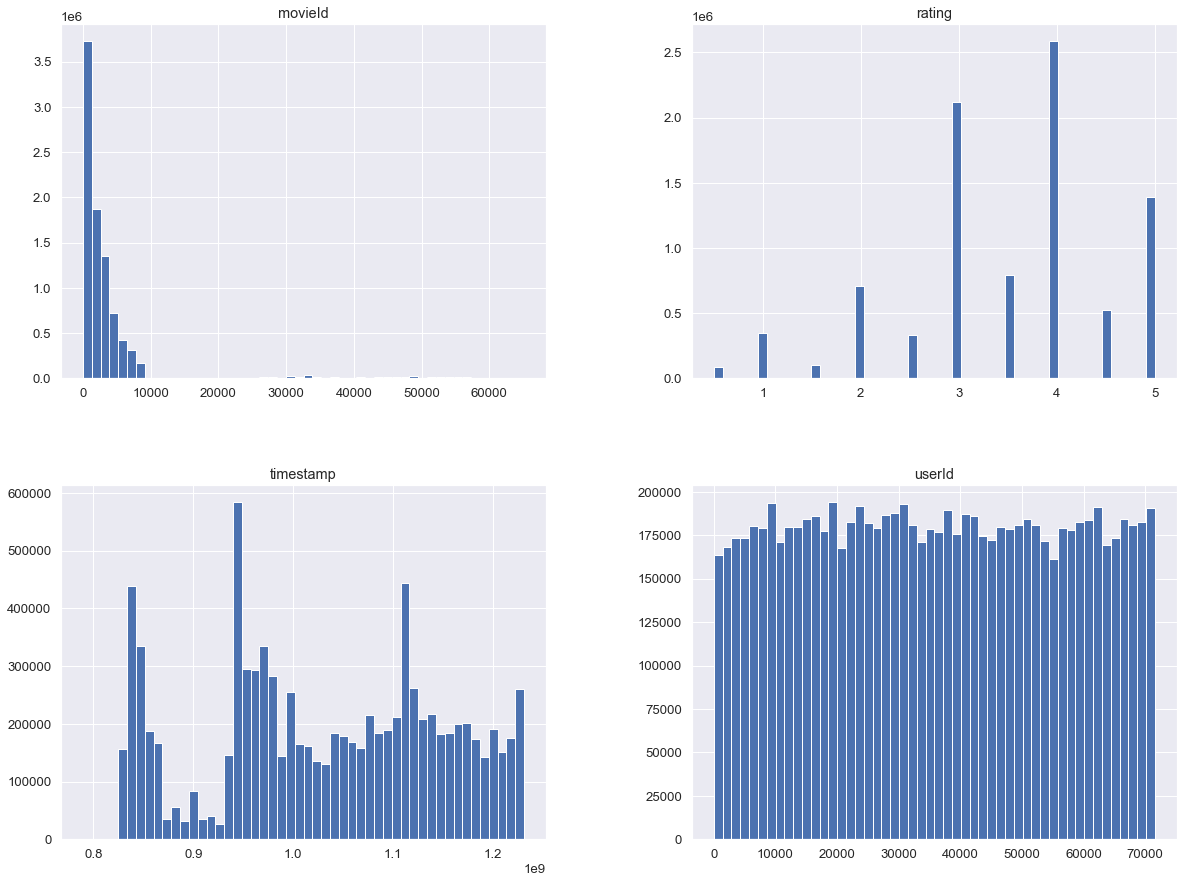

In [9]:
df.hist(bins=50, figsize=(20,15));

### Preprocessing Genre feature

In [10]:
df['genres'].unique()

array(['Comedy|Romance', 'Action|Crime|Thriller',
       'Action|Drama|Sci-Fi|Thriller', 'Action|Adventure|Sci-Fi',
       'Action|Adventure|Drama|Sci-Fi', 'Children|Comedy|Fantasy',
       'Comedy|Drama|Romance|War', 'Adventure|Children|Romance',
       'Adventure|Animation|Children|Drama|Musical', 'Action|Comedy',
       'Action|Romance|Thriller', 'Action|Comedy|Crime|Thriller',
       'Action|Comedy|War', 'Comedy', 'Comedy|Drama|Romance',
       'Adventure|Animation|Children|Comedy|Musical', 'Action|Sci-Fi',
       'Animation|Children|Drama|Fantasy|Musical', 'Animation|Children',
       'Action|Drama|War', 'Action|Thriller', 'Adventure|Drama|Western',
       'Action|Adventure|Mystery|Thriller', 'Action|Adventure|Thriller',
       'Action|Adventure|Romance|Thriller', 'Action|Adventure|Sci-Fi|War',
       'Action|Drama|Thriller', 'Drama|Romance', 'Action|Adventure',
       'Children|Comedy|Fantasy|Musical',
       'Action|Adventure|Sci-Fi|Thriller', 'Action|Comedy|Sci-Fi',
       'Act

### Testing a string first

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
Test = 'Comedy|Romance'

In [13]:
Test_punc_removed = Test.replace('|'," ")

In [14]:
Test_punc_removed

'Comedy Romance'

In [15]:
Test = 'Comedy|Romance'

In [16]:
Test_punc_removed = Test.split('|')

In [17]:
Test_punc_removed

['Comedy', 'Romance']

In [18]:
Test_punc_removed[0]

'Comedy'

In [19]:
Test_punc_removed[1]

'Romance'

In [20]:
#Split the genres into separate columns
df2 = df['genres'].str.split("|",expand=True)

In [21]:
df2

,0,1,2,3,4,5,6,7
0,Comedy,Romance,None,None,None,None,None,None
1,Action,Crime,Thriller,None,None,None,None,None
2,Action,Drama,Sci-Fi,Thriller,None,None,None,None
3,Action,Adventure,Sci-Fi,None,None,None,None,None
4,Action,Adventure,Drama,Sci-Fi,None,None,None,None
...,...,...,...,...,...,...,...,...
9000050,Children,Comedy,None,None,None,None,None,None
9000051,Documentary,None,None,None,None,None,None,None
9000052,Comedy,Musical,Western,None,None,None,None,None
9000053,Documentary,None,None,None,None,None,None,None


In [22]:
df1 = df.join(df2)

In [23]:
df1

,userId,movieId,rating,timestamp,title,genres,0,1,2,3,4,5,6,7
0,1,122,5.0,838985046,Boomerang (1992),Comedy|Romance,Comedy,Romance,None,None,None,None,None,None
1,1,185,5.0,838983525,"Net, The (1995)",Action|Crime|Thriller,Action,Crime,Thriller,None,None,None,None,None
2,1,292,5.0,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,Action,Drama,Sci-Fi,Thriller,None,None,None,None
3,1,316,5.0,838983392,Stargate (1994),Action|Adventure|Sci-Fi,Action,Adventure,Sci-Fi,None,None,None,None,None
4,1,329,5.0,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi,Action,Adventure,Drama,Sci-Fi,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9000050,32620,33140,3.5,1173562747,Down and Derby (2005),Children|Comedy,Children,Comedy,None,None,None,None,None,None
9000051,40976,61913,3.0,1227767528,Africa addio (1966),Documentary,Documentary,None,None,None,None,None,None,None
9000052,59269,63141,2.0,1226443318,Rockin' in the Rockies (1945),Comedy|Musical|Western,Comedy,Musical,Western,None,None,None,None,None
9000053,60713,4820,2.0,1119156754,Won't Anybody Listen? (2000),Documentary,Documentary,None,None,None,None,None,None,None


In [24]:
df1.columns

Index([   'userId',   'movieId',    'rating', 'timestamp',     'title',
          'genres',           0,           1,           2,           3,
                 4,           5,           6,           7],
      dtype='object')

In [25]:
df1.columns = ['userId','movieId','rating','timestamp', 'title','genres','g1','g2','g3','g4','g5','g6','g7','g8']

In [26]:
df1

,userId,movieId,rating,timestamp,title,genres,g1,g2,g3,g4,g5,g6,g7,g8
0,1,122,5.0,838985046,Boomerang (1992),Comedy|Romance,Comedy,Romance,None,None,None,None,None,None
1,1,185,5.0,838983525,"Net, The (1995)",Action|Crime|Thriller,Action,Crime,Thriller,None,None,None,None,None
2,1,292,5.0,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,Action,Drama,Sci-Fi,Thriller,None,None,None,None
3,1,316,5.0,838983392,Stargate (1994),Action|Adventure|Sci-Fi,Action,Adventure,Sci-Fi,None,None,None,None,None
4,1,329,5.0,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi,Action,Adventure,Drama,Sci-Fi,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9000050,32620,33140,3.5,1173562747,Down and Derby (2005),Children|Comedy,Children,Comedy,None,None,None,None,None,None
9000051,40976,61913,3.0,1227767528,Africa addio (1966),Documentary,Documentary,None,None,None,None,None,None,None
9000052,59269,63141,2.0,1226443318,Rockin' in the Rockies (1945),Comedy|Musical|Western,Comedy,Musical,Western,None,None,None,None,None
9000053,60713,4820,2.0,1119156754,Won't Anybody Listen? (2000),Documentary,Documentary,None,None,None,None,None,None,None


In [27]:
df1.fillna(value="Unknown",axis=1,inplace=True)

In [28]:
df1

,userId,movieId,rating,timestamp,title,genres,g1,g2,g3,g4,g5,g6,g7,g8
0,1,122,5.0,838985046,Boomerang (1992),Comedy|Romance,Comedy,Romance,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,1,185,5.0,838983525,"Net, The (1995)",Action|Crime|Thriller,Action,Crime,Thriller,Unknown,Unknown,Unknown,Unknown,Unknown
2,1,292,5.0,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,Action,Drama,Sci-Fi,Thriller,Unknown,Unknown,Unknown,Unknown
3,1,316,5.0,838983392,Stargate (1994),Action|Adventure|Sci-Fi,Action,Adventure,Sci-Fi,Unknown,Unknown,Unknown,Unknown,Unknown
4,1,329,5.0,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi,Action,Adventure,Drama,Sci-Fi,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9000050,32620,33140,3.5,1173562747,Down and Derby (2005),Children|Comedy,Children,Comedy,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
9000051,40976,61913,3.0,1227767528,Africa addio (1966),Documentary,Documentary,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
9000052,59269,63141,2.0,1226443318,Rockin' in the Rockies (1945),Comedy|Musical|Western,Comedy,Musical,Western,Unknown,Unknown,Unknown,Unknown,Unknown
9000053,60713,4820,2.0,1119156754,Won't Anybody Listen? (2000),Documentary,Documentary,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [29]:
df1.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
g1           0
g2           0
g3           0
g4           0
g5           0
g6           0
g7           0
g8           0
dtype: int64

In [30]:
#Save as csv
#df1.to_csv("final.csv",index=False)

### Data Exploration

In [31]:
df1 = pd.read_csv("final.csv")

In [32]:
df1

,userId,movieId,rating,timestamp,title,genres,g1,g2,g3,g4,g5,g6,g7,g8
0,1,122,5.0,838985046,Boomerang (1992),Comedy|Romance,Comedy,Romance,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,1,185,5.0,838983525,"Net, The (1995)",Action|Crime|Thriller,Action,Crime,Thriller,Unknown,Unknown,Unknown,Unknown,Unknown
2,1,292,5.0,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,Action,Drama,Sci-Fi,Thriller,Unknown,Unknown,Unknown,Unknown
3,1,316,5.0,838983392,Stargate (1994),Action|Adventure|Sci-Fi,Action,Adventure,Sci-Fi,Unknown,Unknown,Unknown,Unknown,Unknown
4,1,329,5.0,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi,Action,Adventure,Drama,Sci-Fi,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9000050,32620,33140,3.5,1173562747,Down and Derby (2005),Children|Comedy,Children,Comedy,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
9000051,40976,61913,3.0,1227767528,Africa addio (1966),Documentary,Documentary,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
9000052,59269,63141,2.0,1226443318,Rockin' in the Rockies (1945),Comedy|Musical|Western,Comedy,Musical,Western,Unknown,Unknown,Unknown,Unknown,Unknown
9000053,60713,4820,2.0,1119156754,Won't Anybody Listen? (2000),Documentary,Documentary,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [33]:
#Drop unnecssary columns
del df1['timestamp']

In [34]:
del df1['genres']

In [35]:
del df1['title']

In [36]:
df1

,userId,movieId,rating,g1,g2,g3,g4,g5,g6,g7,g8
0,1,122,5.0,Comedy,Romance,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,1,185,5.0,Action,Crime,Thriller,Unknown,Unknown,Unknown,Unknown,Unknown
2,1,292,5.0,Action,Drama,Sci-Fi,Thriller,Unknown,Unknown,Unknown,Unknown
3,1,316,5.0,Action,Adventure,Sci-Fi,Unknown,Unknown,Unknown,Unknown,Unknown
4,1,329,5.0,Action,Adventure,Drama,Sci-Fi,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
9000050,32620,33140,3.5,Children,Comedy,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
9000051,40976,61913,3.0,Documentary,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
9000052,59269,63141,2.0,Comedy,Musical,Western,Unknown,Unknown,Unknown,Unknown,Unknown
9000053,60713,4820,2.0,Documentary,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [37]:
df1['userId'].nunique()

69878

In [38]:
df1.groupby(by=['userId']).mean()

,movieId,rating
userId,,
1,408.421053,5.000000
2,774.000000,3.294118
3,5612.677419,3.935484
4,360.028571,4.057143
5,656.351351,3.918919
...,...,...
71563,9524.911765,3.441176
71564,2867.258427,3.033708
71565,1980.507812,3.898438


In [39]:
df1['g1'].value_counts()

Action                2560545
Comedy                2437260
Drama                 1741668
Adventure              753650
Crime                  529521
Horror                 233074
Animation              218123
Children               181217
Thriller                94718
Documentary             80966
Sci-Fi                  50254
Mystery                 30536
Fantasy                 26080
Musical                 16264
Film-Noir               15811
Western                 15300
Romance                 12733
War                      2314
IMAX                       14
(no genres listed)          7
Name: g1, dtype: int64

In [40]:
df1['g2'].value_counts()

Unknown        1740569
Drama          1614736
Adventure      1155242
Romance         791222
Comedy          612298
Crime           602588
Thriller        439793
Sci-Fi          363458
Children        339272
Horror          331407
Mystery         252348
Animation       216570
Fantasy         171412
War             146064
Musical         124894
Film-Noir        47280
Western          37052
Documentary      12043
IMAX              1807
Name: g2, dtype: int64

In [41]:
df1['g3'].value_counts()

Unknown        4378344
Thriller        924972
Sci-Fi          663697
Romance         657358
Fantasy         466980
Drama           451995
Comedy          325239
War             237791
Children        208398
Mystery         205883
Crime           134792
Western          93272
Horror           85487
Musical          81495
Film-Noir        49814
Animation        32475
IMAX              2006
Documentary         57
Name: g3, dtype: int64

In [42]:
df1['g4'].value_counts()

Unknown      7099508
Thriller      657340
Sci-Fi        207951
Fantasy       171520
Romance       161946
Comedy        157813
Musical       144526
War           113785
Drama          88295
Mystery        57636
Crime          49795
Western        37723
Horror         33736
Children        9107
Film-Noir       5636
IMAX            3738
Name: g4, dtype: int64

In [43]:
df1['g5'].value_counts()

Unknown     8500887
Thriller     189898
Fantasy       76774
Musical       64550
Romance       61109
Sci-Fi        45338
Drama         13433
Crime         11019
Mystery       10599
War            9351
Comedy         8320
Horror         7525
Western         702
IMAX            550
Name: g5, dtype: int64

In [44]:
df1['g6'].value_counts()

Unknown     8921956
Romance       27217
Thriller      18922
Fantasy       12871
Sci-Fi        10229
Western        5345
War            1842
Musical        1351
Horror          256
IMAX             66
Name: g6, dtype: int64

In [45]:
df1['g7'].value_counts()

Unknown    8987954
Mystery      11330
Romance        515
Sci-Fi         256
Name: g7, dtype: int64

In [46]:
df1['g8'].value_counts()

Unknown     8999799
Thriller        256
Name: g8, dtype: int64

In [47]:
df1['movieId'].value_counts()

296      31362
356      31079
593      30382
480      29360
318      28015
         ...  
58520        1
3226         1
63662        1
31692        1
6085         1
Name: movieId, Length: 10677, dtype: int64

In [48]:
df1['movieId'].nunique()

10677

In [49]:
#df1['title'].value_counts()

In [50]:
#df1['title'].nunique()

In [51]:
df1.groupby(by=['movieId']).mean()

,userId,rating
movieId,,
1,35557.134847,3.927638
2,35824.558957,3.205399
3,35365.566875,3.146983
4,34646.045022,2.864299
5,35233.287187,3.068672
...,...,...
65088,41759.833333,3.500000
65091,29869.333333,3.666667
65126,60123.000000,3.666667


In [52]:
df1.groupby(by=['movieId']).count()

,userId,rating,g1,g2,g3,g4,g5,g6,g7,g8
movieId,,,,,,,,,,
1,23790,23790,23790,23790,23790,23790,23790,23790,23790,23790
2,10779,10779,10779,10779,10779,10779,10779,10779,10779,10779
3,7028,7028,7028,7028,7028,7028,7028,7028,7028,7028
4,1577,1577,1577,1577,1577,1577,1577,1577,1577,1577
5,6400,6400,6400,6400,6400,6400,6400,6400,6400,6400
...,...,...,...,...,...,...,...,...,...,...
65088,6,6,6,6,6,6,6,6,6,6
65091,3,3,3,3,3,3,3,3,3,3
65126,3,3,3,3,3,3,3,3,3,3


In [53]:
df1.groupby(by=['movieId']).sum()

,userId,rating
movieId,,
1,845904238,93438.5
2,386152921,34551.0
3,248549204,22117.0
4,54636813,4517.0
5,225493038,19639.5
...,...,...
65088,250559,21.0
65091,89608,11.0
65126,180369,11.0


In [54]:
rating = pd.DataFrame(df1.groupby('movieId')['rating'].mean())

In [55]:
rating

,rating
movieId,
1,3.927638
2,3.205399
3,3.146983
4,2.864299
5,3.068672
...,...
65088,3.500000
65091,3.666667
65126,3.666667


In [56]:
rating['rating_count'] = pd.DataFrame(df1.groupby('movieId')['rating'].count())

In [57]:
rating

,rating,rating_count
movieId,,
1,3.927638,23790
2,3.205399,10779
3,3.146983,7028
4,2.864299,1577
5,3.068672,6400
...,...,...
65088,3.500000,6
65091,3.666667,3
65126,3.666667,3


In [58]:
#rating.describe()

In [59]:
#table = pd.pivot_table(data=df1, values='rating', index=['userId'],columns=['movieId'])

In [60]:
#table

In [61]:
rating.reset_index(inplace=True)

In [62]:
rating

,movieId,rating,rating_count
0,1,3.927638,23790
1,2,3.205399,10779
2,3,3.146983,7028
3,4,2.864299,1577
4,5,3.068672,6400
...,...,...,...
10672,65088,3.500000,6
10673,65091,3.666667,3
10674,65126,3.666667,3
10675,65130,2.250000,2


In [63]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10677 entries, 0 to 10676
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       10677 non-null  int64  
 1   rating        10677 non-null  float64
 2   rating_count  10677 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 250.4 KB


### Load Test Dataset and preprocess it

In [64]:
test = pd.read_csv("test.csv")

In [65]:
test

,userId,movieId,rating,timestamp,title,genres
0,1,231,5.0,838983392,Dumb & Dumber (1994),Comedy
1,1,480,5.0,838983653,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
2,1,586,5.0,838984068,Home Alone (1990),Children|Comedy
3,2,151,3.0,868246450,Rob Roy (1995),Action|Drama|Romance|War
4,2,858,2.0,868245645,"Godfather, The (1972)",Crime|Drama
...,...,...,...,...,...,...
999994,71566,235,5.0,830341062,Ed Wood (1994),Comedy|Drama
999995,71566,273,3.0,830341118,Frankenstein (Mary Shelley's Frankenstein) (1994),Drama|Horror
999996,71566,434,3.0,830340953,Cliffhanger (1993),Action|Adventure|Thriller
999997,71567,480,4.0,912580688,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


In [66]:
#Drop unnecssary columns
del test['timestamp']

In [67]:
del test['genres']

In [68]:
del test['title']

In [69]:
test

,userId,movieId,rating
0,1,231,5.0
1,1,480,5.0
2,1,586,5.0
3,2,151,3.0
4,2,858,2.0
...,...,...,...
999994,71566,235,5.0
999995,71566,273,3.0
999996,71566,434,3.0
999997,71567,480,4.0


In [70]:
test_rating = pd.DataFrame(test.groupby('movieId')['rating'].mean())

In [71]:
test_rating

,rating
movieId,
1,3.938887
2,3.231045
3,3.181759
4,2.828877
5,3.153741
...,...
64983,2.625000
64997,3.166667
64999,1.000000


In [72]:
test_rating['rating_count'] = pd.DataFrame(test.groupby('movieId')['rating'].count())

In [73]:
test_rating

,rating,rating_count
movieId,,
1,3.938887,2659
2,3.231045,1253
3,3.181759,762
4,2.828877,187
5,3.153741,735
...,...,...
64983,2.625000,4
64997,3.166667,3
64999,1.000000,1


In [74]:
test_rating.reset_index(inplace=True)

In [75]:
test_rating

,movieId,rating,rating_count
0,1,3.938887,2659
1,2,3.231045,1253
2,3,3.181759,762
3,4,2.828877,187
4,5,3.153741,735
...,...,...,...
9804,64983,2.625000,4
9805,64997,3.166667,3
9806,64999,1.000000,1
9807,65088,1.750000,2


### Model Training

### Using PyCaret

In [76]:
exp_reg = setup(data = rating, target = 'rating', session_id=123, normalize=True, train_size=0.8) 

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(10677, 3)"
4,Missing Values,False
5,Numeric Features,2
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [77]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.402400,0.264300,0.514000,0.178300,0.134200,0.145600
1,Light Gradient Boosting Machine,0.402700,0.264900,0.514600,0.176300,0.134200,0.145600
2,Extreme Gradient Boosting,0.406600,0.268400,0.517900,0.165600,0.135200,0.147400
3,Gradient Boosting Regressor,0.406800,0.269300,0.518700,0.162900,0.135500,0.147500
4,Random Forest,0.413900,0.289400,0.537800,0.099500,0.139400,0.148400
5,Support Vector Machine,0.421000,0.294300,0.542300,0.085400,0.142200,0.156300
6,Linear Regression,0.438800,0.306100,0.553100,0.048100,0.143500,0.158800
7,Ridge Regression,0.438800,0.306100,0.553100,0.048100,0.143500,0.158800
8,Least Angle Regression,0.438800,0.306100,0.553100,0.048100,0.143500,0.158800
9,Bayesian Ridge,0.438800,0.306100,0.553100,0.048100,0.143500,0.158800


In [78]:
cat = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3909,0.2484,0.4984,0.1898,0.1311,0.1427
1,0.3937,0.2421,0.4920,0.1731,0.1231,0.1321
2,0.4007,0.2609,0.5108,0.1858,0.1325,0.1433
3,0.4170,0.2848,0.5337,0.1538,0.1406,0.1522
4,0.3951,0.2568,0.5067,0.1916,0.1318,0.1419
5,0.4184,0.2838,0.5327,0.1652,0.1391,0.1517
6,0.4067,0.2657,0.5154,0.1509,0.1344,0.1466
7,0.3969,0.2608,0.5107,0.1954,0.1344,0.1453
8,0.4006,0.2614,0.5113,0.2078,0.1314,0.1422
9,0.4040,0.2788,0.5280,0.1692,0.1431,0.1582


In [79]:
print(cat)

In [80]:
tuned_cat = tune_model('catboost', optimize='mse')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3995,0.2600,0.5099,0.1519,0.1341,0.1463
1,0.3959,0.2442,0.4941,0.1660,0.1237,0.1330
2,0.4039,0.2626,0.5125,0.1805,0.1332,0.1448
3,0.4218,0.2908,0.5393,0.1360,0.1419,0.1540
4,0.4027,0.2638,0.5136,0.1695,0.1336,0.1447
5,0.4230,0.2914,0.5398,0.1427,0.1406,0.1532
6,0.4122,0.2729,0.5224,0.1279,0.1360,0.1485
7,0.4001,0.2636,0.5134,0.1868,0.1352,0.1467
8,0.4079,0.2696,0.5192,0.1832,0.1334,0.1449
9,0.4123,0.2881,0.5367,0.1415,0.1451,0.1608


In [81]:
print(tuned_cat)

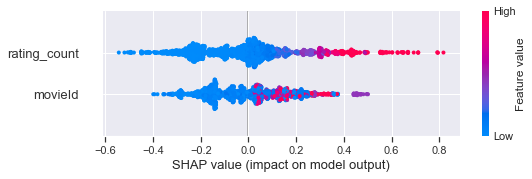

In [82]:
interpret_model(tuned_cat)

In [83]:
predict_model(tuned_cat)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.4195,0.2818,0.5308,0.1763,0.1384,0.1511


,movieId,rating_count,rating,Label
0,-0.579906,0.820265,4.027436,3.3369
1,-0.487784,-0.025437,4.087786,3.2834
2,-0.336138,-0.359608,3.671053,3.3244
3,1.829676,-0.364076,3.535714,3.0151
4,-0.329224,-0.365863,3.000000,2.9762
...,...,...,...,...
2131,-0.668376,5.990978,4.037466,4.1918
2132,-0.330180,-0.368097,2.868421,2.9351
2133,-0.280043,-0.356034,3.478261,3.3592
2134,1.833274,0.991371,3.450196,3.7631


In [84]:
predict_model(tuned_cat, data=test_rating)

,movieId,rating,rating_count,Label
0,1,3.938887,2659,3.3399
1,2,3.231045,1253,3.1503
2,3,3.181759,762,3.2159
3,4,2.828877,187,3.2588
4,5,3.153741,735,3.2159
...,...,...,...,...
9804,64983,2.625000,4,3.2094
9805,64997,3.166667,3,3.2094
9806,64999,1.000000,1,2.9021
9807,65088,1.750000,2,3.2655
